In [21]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby, chain
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [56]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [57]:
NMER = 5
CONTEXT = 200

In [58]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [59]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [60]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>burn-in lambda_ref']
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


## Analysis 

In [61]:
KMER = "ACTGC"

In [62]:
events = [ev for ev in true_events if ev["kmer"] == KMER]

In [63]:
len(events)

6141

In [64]:
events[0]

{'channel': 105,
 'complement.end': 35647746.0,
 'complement.mean': 72.61394808593752,
 'complement.start': 35647538.0,
 'complement.stdv': 0.9822936215940927,
 'file_id': 17,
 'kmer': 'ACTGC',
 'move': 1,
 'ref_position': 395,
 'template.end': 34479704.0,
 'template.mean': 55.85186889648438,
 'template.start': 34479657.0,
 'template.stdv': 1.74295447942741}

In [65]:
key = lambda x: x["ref_position"]
events = sorted(events, key=key)
positions = {pos: [x["template.mean"] for x in group] for (pos, group) in groupby(events, key=key)}
mlen = max([len(group) for group in positions.values()])
df = pandas.DataFrame({pos: group + (mlen - len(group)) * [np.nan] for pos, group in positions.items() if pos < 10000})

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


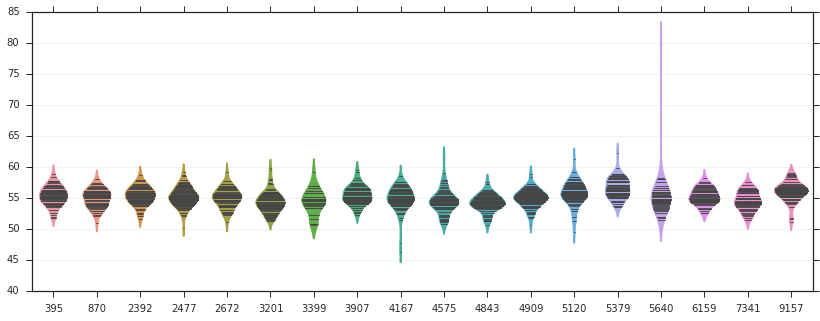

In [66]:
fig, ax = subplots(figsize=(14, 5))
sns.violinplot(df, ax=ax, inner="stick")

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


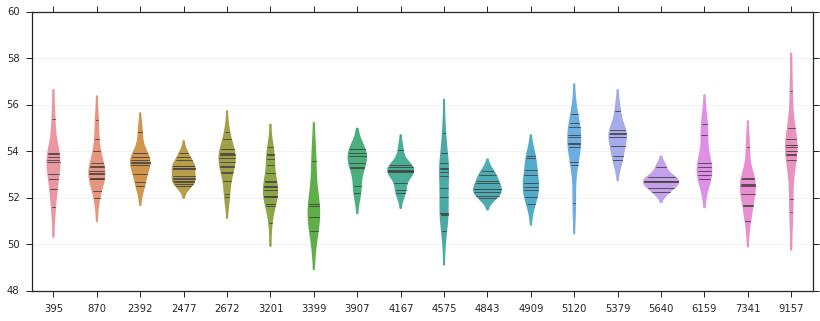

In [55]:
fig, ax = subplots(figsize=(14, 5))
sns.violinplot(df, ax=ax, inner="stick")